In [7]:
!mamba install pandas
!mamba install seaborn 
!mamba install Scikit-learn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
import os
from pathlib import Path

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn, Scikit-learn
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.7381000000238419 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn, Scikit-learn
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.4265 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, seaborn, Scikit-learn
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 0.4326999999284744 seconds
All requested packages already installed.


In [10]:
def load_titanic_data():
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    try:
        df = pd.read_csv(url)
        df.columns = df.columns.str.lower()
        print("Загружено", len(df), "записей через GitHub")
        return df
    except Exception as e2:
        print("Ошибка загрузки:", e2)
        return None
df = load_titanic_data()
print("\nПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ")
print("="*60)
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика:")
print(df.describe())
df_processed = df.copy()

Загружено 891 записей через GitHub

ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ
Размер данных: (891, 12)

Первые 5 строк:
   passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3     


ОБРАБОТКА ПРОПУСКОВ:
   age заполнен медианой: 28.0
   embarked заполнен модой: S

 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ:
   family_size создан
   is_alone создан
   age_group создан
   fare_per_person создан

3. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:
   sex закодирован: {'female': np.int32(0), 'male': np.int32(1)}
   embarked закодирован (one-hot)
   pclass закодирован (one-hot)

4. ИТОГОВЫЙ НАБОР ПРИЗНАКОВ:
   Признаки (10): ['age', 'fare', 'family_size', 'is_alone', 'fare_per_person', 'sex_encoded', 'embarked_Q', 'embarked_S', 'pclass_2', 'pclass_3']
   Целевая переменная: survived
   Доступно признаков: 10
   Размер данных для моделирования: (891, 11)
   Размер данных для моделирования: (891, 11)

Точность на обучающей выборке: 0.9817
Точность на тестовой выборке: 0.8045
Разница (переобучение): 0.1773

Глубина дерева: 21
Количество листьев: 150
ВИЗУАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ

 ТЕКСТОВОЕ ПРЕДСТАВЛЕНИЕ ДЕРЕВА (первые 20 строк):
|--- sex_encoded <= 0.50
|   |--- pclass_3 <= 0.50
|   |   |--- fare <=

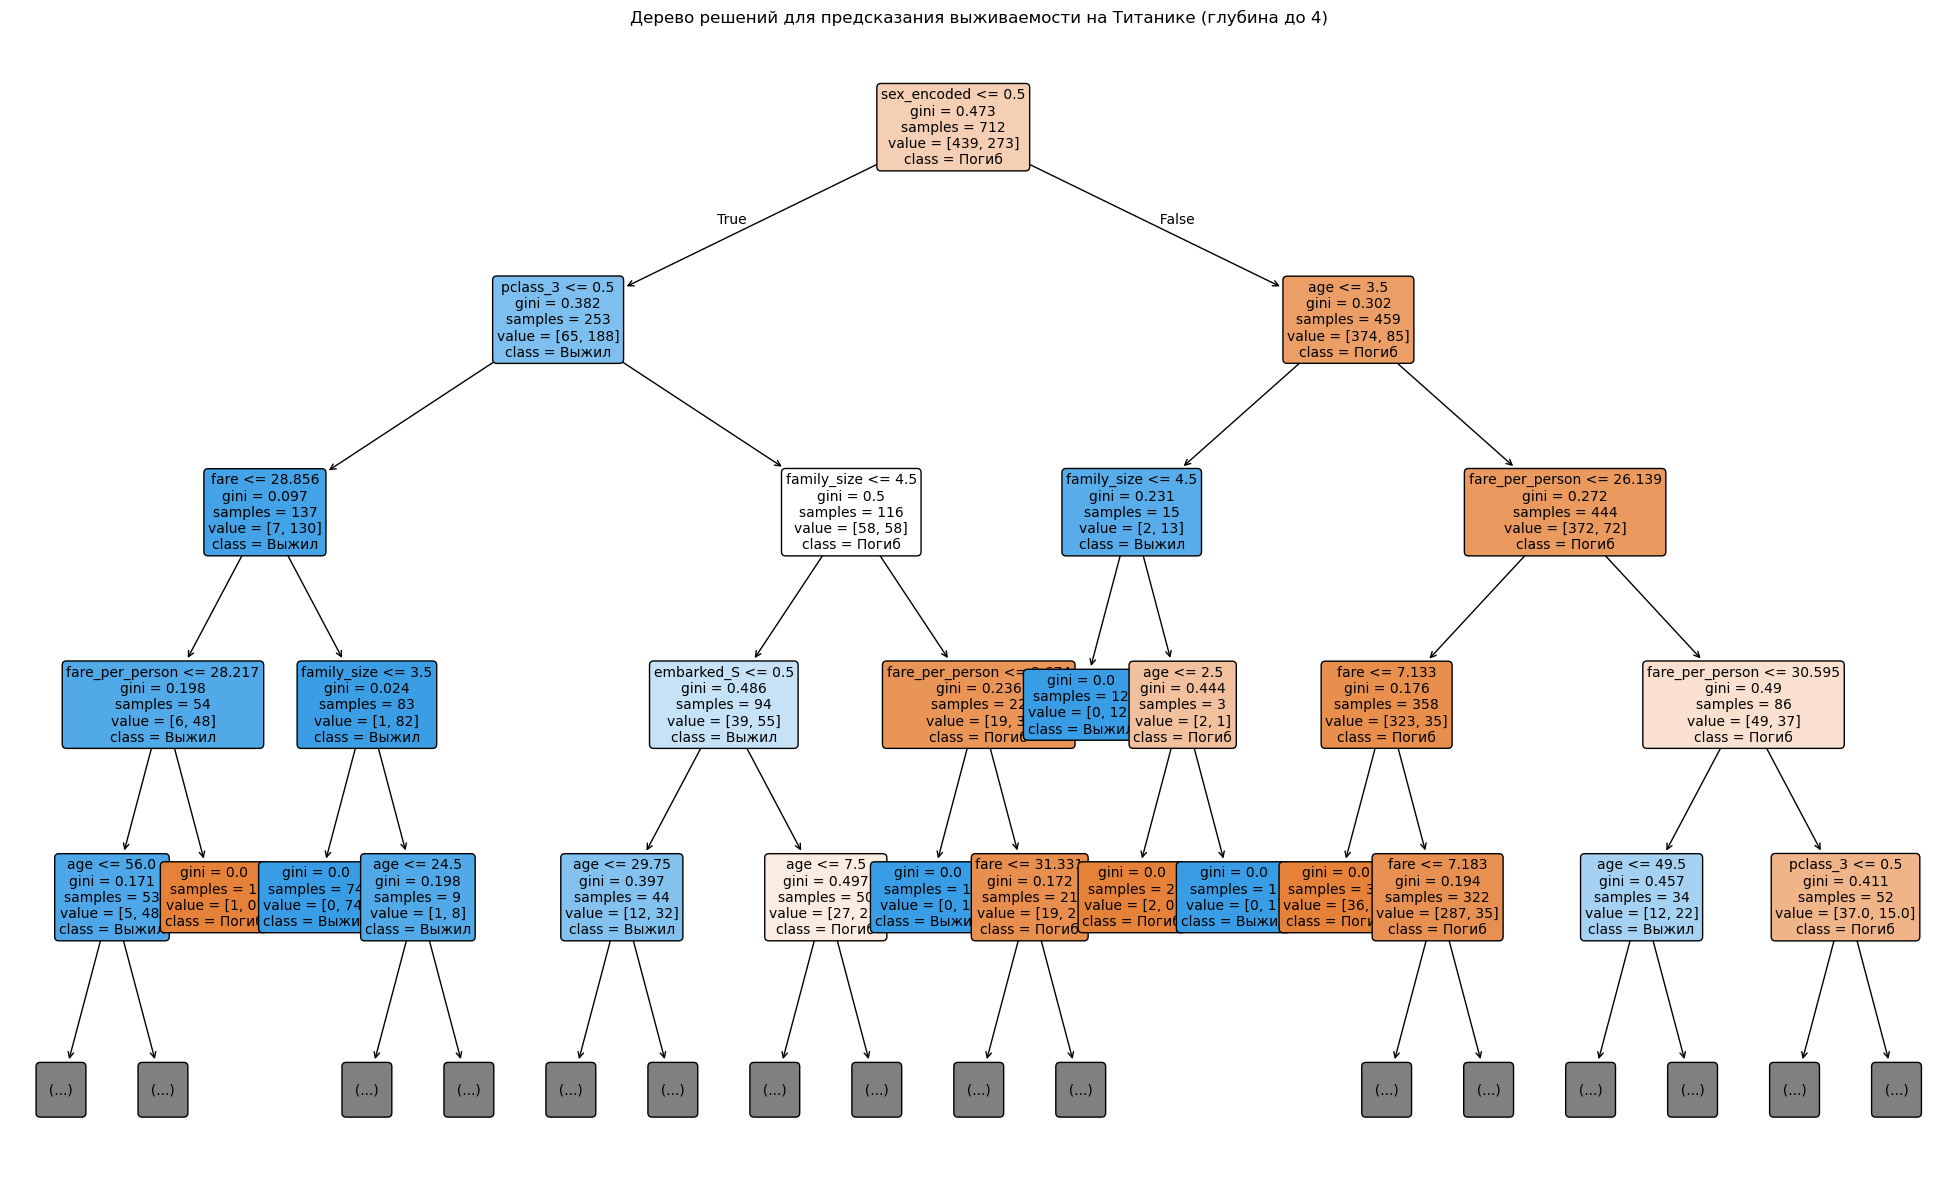

Графическое дерево сохранено в 'results/decision_tree_visual.png'


In [11]:
print("\nОБРАБОТКА ПРОПУСКОВ:")

if 'age' in df_processed.columns:
    age_median = df_processed['age'].median()
    df_processed['age'] = df_processed['age'].fillna(age_median)
    print(f"   age заполнен медианой: {age_median:.1f}")

if 'embarked' in df_processed.columns:
    embarked_mode = df_processed['embarked'].mode()[0]
    df_processed['embarked'] = df_processed['embarked'].fillna(embarked_mode)
    print(f"   embarked заполнен модой: {embarked_mode}")

# Удаляем колонки с большим количеством пропусков
cols_to_drop = ['deck', 'embark_town', 'alive', 'alone', 'who', 'adult_male']
for col in cols_to_drop:
    if col in df_processed.columns:
        df_processed = df_processed.drop(col, axis=1)
        print(f"   {col} удалена")

print("\n СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ:")

if 'sibsp' in df_processed.columns and 'parch' in df_processed.columns:
    df_processed['family_size'] = df_processed['sibsp'] + df_processed['parch'] + 1
    print("   family_size создан")

if 'family_size' in df_processed.columns:
    df_processed['is_alone'] = (df_processed['family_size'] == 1).astype(int)
    print("   is_alone создан")

if 'age' in df_processed.columns:
    bins = [0, 12, 18, 35, 50, 65, 100]
    labels = ['child', 'teen', 'young_adult', 'adult', 'middle_age', 'senior']
    df_processed['age_group'] = pd.cut(df_processed['age'], bins=bins, labels=labels)
    print("   age_group создан")

if 'fare' in df_processed.columns and 'family_size' in df_processed.columns:
    df_processed['fare_per_person'] = df_processed['fare'] / df_processed['family_size']
    print("   fare_per_person создан")

print("\n3. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")

if 'sex' in df_processed.columns:
    le_sex = LabelEncoder()
    df_processed['sex_encoded'] = le_sex.fit_transform(df_processed['sex'])
    print(f"   sex закодирован: {dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))}")

if 'embarked' in df_processed.columns:
    embarked_dummies = pd.get_dummies(df_processed['embarked'], prefix='embarked', drop_first=True)
    df_processed = pd.concat([df_processed, embarked_dummies], axis=1)
    print("   embarked закодирован (one-hot)")

if 'pclass' in df_processed.columns:
    pclass_dummies = pd.get_dummies(df_processed['pclass'], prefix='pclass', drop_first=True)
    df_processed = pd.concat([df_processed, pclass_dummies], axis=1)
    print("   pclass закодирован (one-hot)")

print("\n4. ИТОГОВЫЙ НАБОР ПРИЗНАКОВ:")

feature_columns = []
numeric_features = ['age', 'fare', 'family_size', 'is_alone', 'fare_per_person']
for col in numeric_features:
    if col in df_processed.columns:
        feature_columns.append(col)

if 'sex_encoded' in df_processed.columns:
    feature_columns.append('sex_encoded')

for col in df_processed.columns:
    if col.startswith('embarked_') or col.startswith('pclass_'):
        feature_columns.append(col)

# Целевая переменная
target_column = 'survived'

print(f"   Признаки ({len(feature_columns)}): {feature_columns}")
print(f"   Целевая переменная: {target_column}")

# Проверяем наличие всех колонок
available_features = [col for col in feature_columns if col in df_processed.columns]
print(f"   Доступно признаков: {len(available_features)}")

# Создаем финальный DataFrame для моделирования
df_model = df_processed[available_features + [target_column]].copy()
print(f"   Размер данных для моделирования: {df_model.shape}")

print(f"   Размер данных для моделирования: {df_model.shape}")
X = df_model.drop(target_column, axis=1)
y = df_model[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
dt_base = DecisionTreeClassifier(random_state=42)

dt_base.fit(X_train, y_train)

y_train_pred_base = dt_base.predict(X_train)
train_acc_base = accuracy_score(y_train, y_train_pred_base)

y_pred_base = dt_base.predict(X_test)
test_acc_base = accuracy_score(y_test, y_pred_base)

print(f"\nТочность на обучающей выборке: {train_acc_base:.4f}")
print(f"Точность на тестовой выборке: {test_acc_base:.4f}")
print(f"Разница (переобучение): {train_acc_base - test_acc_base:.4f}")

# Глубина дерева
print(f"\nГлубина дерева: {dt_base.get_depth()}")
print(f"Количество листьев: {dt_base.get_n_leaves()}")

print("ВИЗУАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ")

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

print("\n ТЕКСТОВОЕ ПРЕДСТАВЛЕНИЕ ДЕРЕВА (первые 20 строк):")
tree_text = export_text(dt_base, feature_names=list(X.columns), max_depth=3)
print(tree_text)

with open(results_dir / "decision_tree_text.txt", 'w') as f:
    f.write(export_text(dt_base, feature_names=list(X.columns)))
print("Полное текстовое дерево сохранено в 'results/decision_tree_text.txt'")

plt.figure(figsize=(25, 15))
plot_tree(dt_base, feature_names=list(X.columns), class_names=['Погиб', 'Выжил'], 
          filled=True, rounded=True, fontsize=10, max_depth=4)
plt.title('Дерево решений для предсказания выживаемости на Титанике (глубина до 4)')
plt.savefig(results_dir / "decision_tree_visual.png", dpi=150, bbox_inches='tight')
plt.show()
print("Графическое дерево сохранено в 'results/decision_tree_visual.png'")


 ОСНОВНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
   Accuracy (точность): 0.8045
   Precision (точность положительных предсказаний): 0.7500
   Recall (полнота): 0.7391
   F1-score (гармоническое среднее): 0.7445

 МАТРИЦА ОШИБОК:
[[93 17]
 [18 51]]


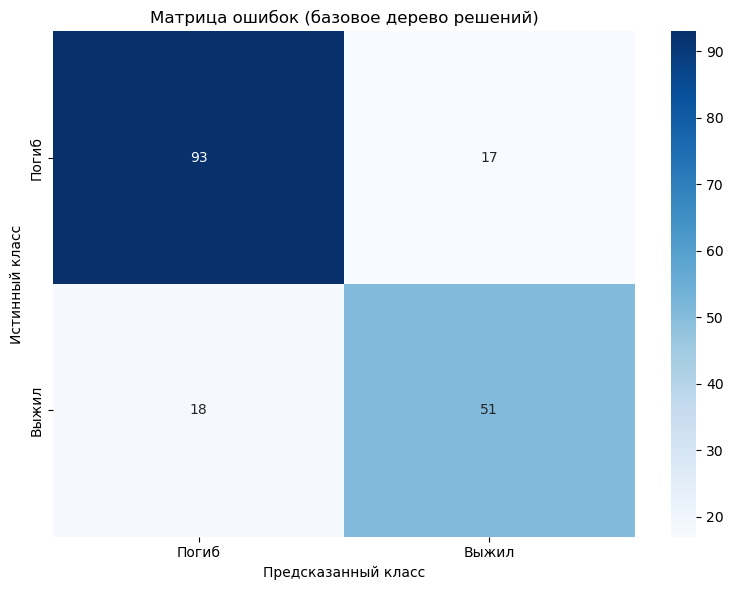


 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

       Погиб       0.84      0.85      0.84       110
       Выжил       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


 КРОСС-ВАЛИДАЦИЯ (5-fold):
   Точность на кросс-валидации: 0.7585 (+/- 0.0931)

 ROC-КРИВАЯ:


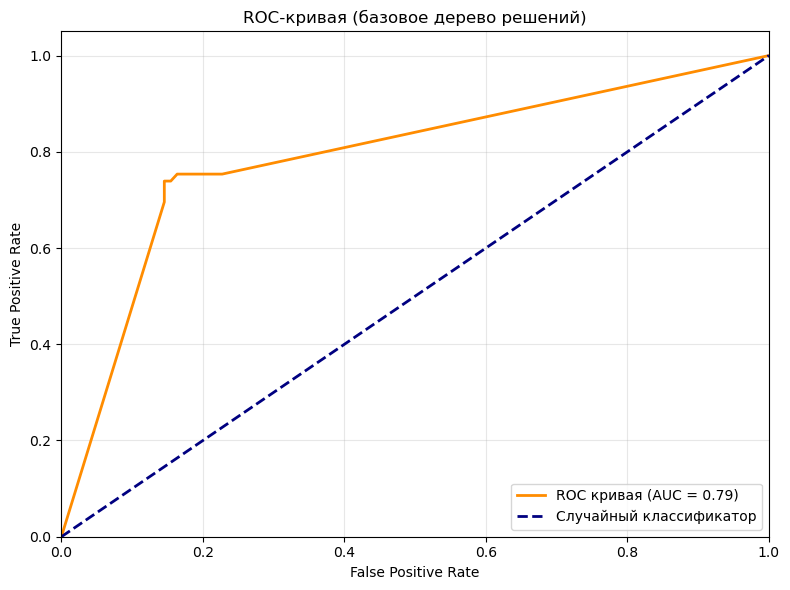

   AUC (площадь под ROC-кривой): 0.7896


In [12]:
print("\n ОСНОВНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")

accuracy = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base)
recall = recall_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

print(f"   Accuracy (точность): {accuracy:.4f}")
print(f"   Precision (точность положительных предсказаний): {precision:.4f}")
print(f"   Recall (полнота): {recall:.4f}")
print(f"   F1-score (гармоническое среднее): {f1:.4f}")

print("\n МАТРИЦА ОШИБОК:")
cm = confusion_matrix(y_test, y_pred_base)
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Погиб', 'Выжил'], 
            yticklabels=['Погиб', 'Выжил'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (базовое дерево решений)')
plt.tight_layout()
plt.savefig(results_dir / "confusion_matrix_base.png", dpi=150)
plt.show()

print("\n ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
print(classification_report(y_test, y_pred_base, target_names=['Погиб', 'Выжил']))

print("\n КРОСС-ВАЛИДАЦИЯ (5-fold):")
cv_scores = cross_val_score(dt_base, X_train, y_train, cv=5, scoring='accuracy')
print(f"   Точность на кросс-валидации: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n ROC-КРИВАЯ:")

y_pred_proba = dt_base.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (базовое дерево решений)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(results_dir / "roc_curve_base.png", dpi=150)
plt.show()

print(f"   AUC (площадь под ROC-кривой): {roc_auc:.4f}")
